# 지진해일대피소 현황 분석 및 개선 방안 제시

In [1]:
import pandas as pd 
import folium 
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
from folium import Map


#설치 안된거는 설치해주세요

In [2]:
# 파이그래프에서 한국어 나오게 하는 코드 

import matplotlib.font_manager as fm

for font in fm.fontManager.ttflist:
    if font.name in ['AppleGothic', 'Malgun Gothic']:
        plt.rcParams['font.family'] = font.name
        break

plt.rcParams['font.family']

['AppleGothic']

# 선택한  데이터 
- 전국지진해일대피소표준데이터
    - 통합, 광명시 
- KOSIS 행정구역(시군구)별 인구 통계 데이터 

# EDA

## 서울특별시, 인천광역시, 경기도 데이터만 추출
### 특이사항
- 소재지도로명주소와 소재지지번주소 둘 중 하나만 기입되어 도로명 주소 결측치는 소재지지번주소 컬럼에서 가져옴
- 경기도 광명시 데이터가 몇일 전에 올라와서 따로 다운받아 전국 통합본에 합침

### 과정
1. 주소를 string type으로 변환
2. 띄어쓰기를 기준으로 첫번째 덩어리 ('서울특별시', '인천광역시', '경기도' 등등)만 'area' 컬럼으로 저장 
3. area가 '서울특별시', '인천광역시', '경기도'인건만 새로운 테이블(shelter_GG)로 저장 

In [4]:
shelter = pd.read_csv('전국지진해일대피소표준데이터.csv', encoding = "CP949")

In [5]:
len(shelter)

10305

In [6]:
kwangmyung = pd.read_csv('경기도_광명시_지진해일대피소_20190909.csv', encoding = "CP949")

FileNotFoundError: [Errno 2] File b'\xea\xb2\xbd\xea\xb8\xb0\xeb\x8f\x84_\xea\xb4\x91\xeb\xaa\x85\xec\x8b\x9c_\xec\xa7\x80\xec\xa7\x84\xed\x95\xb4\xec\x9d\xbc\xeb\x8c\x80\xed\x94\xbc\xec\x86\x8c_20190909.csv' does not exist: b'\xea\xb2\xbd\xea\xb8\xb0\xeb\x8f\x84_\xea\xb4\x91\xeb\xaa\x85\xec\x8b\x9c_\xec\xa7\x80\xec\xa7\x84\xed\x95\xb4\xec\x9d\xbc\xeb\x8c\x80\xed\x94\xbc\xec\x86\x8c_20190909.csv'

In [6]:
len(kwangmyung)

93

In [7]:
pd.DataFrame(kwangmyung.isnull().sum())

,0
지진해일대피소명,0
지진해일대피소구분,0
지진해일대피소유형,0
지진해일대피소유형구분,0
소재지도로명주소,23
소재지지번주소,0
위도,0
경도,0
수용가능면적,0
최대수용인원수,0


In [8]:
kwangmyung['제공기관명'] = '경기도 광명시'

In [9]:
shelter = pd.concat([shelter, kwangmyung], ignore_index = True, sort = False)

In [10]:
len(shelter)

10398

In [11]:
shelter.columns

Index(['지진해일대피소명', '지진해일대피소구분', '지진해일대피소유형', '지진해일대피소유형구분', '소재지도로명주소',
       '소재지지번주소', '위도', '경도', '수용가능면적', '최대수용인원수', '지진해일대피소운영상태',
       '지진해일대피소전화번호', '부대편의시설', '주민대피지구명', '주민대피지구내가구수', '주민대피지구내거주인수',
       '주민대피지구내재해약자수', '내진적용여부', '내진설계등급', '해안선이격거리', '해발높이', '지진대피안내표지판수',
       '긴급대피장소안내표지판수', '지진대피로안내표지판수', '관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드',
       '제공기관명', 'Unnamed: 29'],
      dtype='object')

# 위도 경도 결측치 채우기 
 
1. 위도, 경도 결측치인 행만 빼서 하나의 테이블(nulls)로 저장 
    - 정해진 API이용횟수 때문
2. KAKAO API와 LOCATIONIQ API 활용해서 위도 경도 찾음 
3. 두 API로도 안나온 주소지는 손수 찾아서 채움 
4. 본래 통합본에 결측치 테이블(nulls) LEFT JOIN해서 최종 테이블(shelter_G)로 저장
5. 위도, 경도 결측치 남은 것 없는지 확인

In [12]:
shelter[shelter['소재지도로명주소'].isnull()]

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,해발높이,지진대피안내표지판수,긴급대피장소안내표지판수,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29
1042,강하생활체육공원,지진대피소,옥외대피소,공원,NaN,경기도 양평군 강하면 운심리 57번지,37.497379,127.413071,10000.0,12121.0,...,32.0,1.0,0.0,0.0,강하면,031-770-3089,2019-03-01,4170000.0,경기도 양평군,NaN
1046,단월레포츠공원,지진대피소,옥외대피소,공원,NaN,경기도 양평군 단월면 보룡리 산 11-1,37.544436,127.670154,10000.0,12121.0,...,112.0,1.0,0.0,0.0,단월면,031-770-3213,2019-03-01,4170000.0,경기도 양평군,NaN
1052,서동공원 서문주차장,지진대피소,옥외대피소,기타,NaN,충청남도 부여군 부여읍 동남리 172-1,36.271127,126.909818,13736.0,4000.0,...,NaN,0.0,0.0,0.0,충청남도 부여군청,041-830-2630,2018-10-01,4570000.0,충청남도 부여군,NaN
1098,솔터체육공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 마산동 642-1,37.640454,126.649226,193990.0,58785.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1099,모담공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 운양동 1325-1,37.648470,126.689301,536255.0,162501.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1100,조류생태공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 운양동 1246-1,37.657766,126.690011,565295.0,171301.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1101,걸포중앙공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 걸포동 1553,37.638067,126.706824,134481.0,40752.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1102,한강신도시 근린7호 공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 장기동 1888-15,37.641139,126.658917,99736.0,30223.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1103,양곡 제4근린공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 양촌읍 양곡리 1331,37.653057,126.629209,42860.0,12988.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1104,골드밸리 근린5호,지진대피소,옥외대피소,공원,NaN,경기도 김포시 양촌읍 학운리 3152,37.621077,126.629363,42308.0,12821.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN


In [13]:
len(shelter[shelter['소재지도로명주소'].isnull()])

949

In [14]:
len(shelter[shelter['소재지도로명주소'].isnull()&shelter['소재지지번주소'].isnull()])

0

In [15]:
shelter[shelter['소재지도로명주소'].isnull()].head()

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,해발높이,지진대피안내표지판수,긴급대피장소안내표지판수,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29
1042,강하생활체육공원,지진대피소,옥외대피소,공원,NaN,경기도 양평군 강하면 운심리 57번지,37.497379,127.413071,10000.0,12121.0,...,32.0,1.0,0.0,0.0,강하면,031-770-3089,2019-03-01,4170000.0,경기도 양평군,NaN
1046,단월레포츠공원,지진대피소,옥외대피소,공원,NaN,경기도 양평군 단월면 보룡리 산 11-1,37.544436,127.670154,10000.0,12121.0,...,112.0,1.0,0.0,0.0,단월면,031-770-3213,2019-03-01,4170000.0,경기도 양평군,NaN
1052,서동공원 서문주차장,지진대피소,옥외대피소,기타,NaN,충청남도 부여군 부여읍 동남리 172-1,36.271127,126.909818,13736.0,4000.0,...,NaN,0.0,0.0,0.0,충청남도 부여군청,041-830-2630,2018-10-01,4570000.0,충청남도 부여군,NaN
1098,솔터체육공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 마산동 642-1,37.640454,126.649226,193990.0,58785.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN
1099,모담공원,지진대피소,옥외대피소,공원,NaN,경기도 김포시 운양동 1325-1,37.648470,126.689301,536255.0,162501.0,...,NaN,NaN,NaN,NaN,김포시,031-980-2914,2019-09-10,4090000.0,경기도 김포시,NaN


In [16]:
shelter['소재지도로명주소'] = shelter['소재지도로명주소'].fillna(shelter['소재지지번주소'])

In [17]:
shelter[shelter['소재지도로명주소'].isnull()]

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,해발높이,지진대피안내표지판수,긴급대피장소안내표지판수,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29


In [18]:
shelter['소재지도로명주소'][1103]

'경기도 김포시 양촌읍 양곡리 1331'

In [19]:
# 소재지도로명주소 string타입으로 변형 
shelter['소재지도로명주소'] = shelter['소재지도로명주소'].astype('str')

In [20]:
# 소재지도로명 띄어쓰기 기준으로 잘라 첫번째 덩어리만 area 컬럼에 저장
shelter['area'] = shelter['소재지도로명주소'].str.split(' ').str[0]

In [21]:
shelter.head()

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,지진대피안내표지판수,긴급대피장소안내표지판수,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29,area
0,내수2근린공원,지진대피소,옥외대피소,공원,서울특별시 종로구 경희궁4길,서울특별시 종로구 내수동 73-3,37.572387,126.971583,2192.0,664.0,...,NaN,NaN,NaN,종로구청,02-2148-2483,2018-08-14,3000000.0,서울특별시 종로구,NaN,서울특별시
1,대동세무고등학교,지진대피소,옥외대피소,운동장,서울특별시 종로구 계동길 84-10,NaN,37.581920,126.987930,2000.0,1000.0,...,NaN,NaN,NaN,종로구청,02-2148-2483,2018-08-14,3000000.0,서울특별시 종로구,NaN,서울특별시
2,대신고등학교,지진대피소,옥외대피소,운동장,서울특별시 종로구 사직로 9,NaN,37.572915,126.961601,4663.0,1413.0,...,NaN,NaN,NaN,종로구청,02-2148-2483,2018-08-14,3000000.0,서울특별시 종로구,NaN,서울특별시
3,덕성여자고등학교,지진대피소,옥외대피소,운동장,서울특별시 종로구 율곡로3길 50,NaN,37.577918,126.982867,4180.0,1260.0,...,NaN,NaN,NaN,종로구청,02-2148-2483,2018-08-14,3000000.0,서울특별시 종로구,NaN,서울특별시
4,덕성여자중학교,지진대피소,옥외대피소,운동장,서울특별시 종로구 율곡로3길 49,NaN,37.577945,126.981778,6701.0,2030.0,...,NaN,NaN,NaN,종로구청,02-2148-2483,2018-08-14,3000000.0,서울특별시 종로구,NaN,서울특별시


In [22]:
shelter.area.unique()

array(['서울특별시', '충청북도', '경기도', '인천광역시', '경상남도', '강원도', '전라북도', '광주광역시',
       '경상북도', '충청남도', '부산광역시', '대구광역시', '전라남도', '대전광역시', '울산광역시',
       '제주특별자치도', '세종특별자치시'], dtype=object)

In [23]:
shelter_GG = shelter[(shelter['area']=='서울특별시')|(shelter['area']=='인천광역시')|(shelter['area']=='경기도')]

In [24]:
shelter_GG.area.unique()

array(['서울특별시', '경기도', '인천광역시'], dtype=object)

In [25]:
len(shelter_GG)

3250

In [26]:
# 컬럼별 null값 찾기
data = shelter_GG.isnull().sum()
pd.DataFrame(data)

,0
지진해일대피소명,0
지진해일대피소구분,0
지진해일대피소유형,0
지진해일대피소유형구분,0
소재지도로명주소,0
소재지지번주소,2065
위도,72
경도,71
수용가능면적,0
최대수용인원수,0


In [27]:
nulls = shelter_GG[shelter_GG['위도'].isnull()]

In [28]:
# from geocoder import geocode

In [29]:
# lats = []
# lngs = []

# for i, index in enumerate(nulls.index):
#     print(i + 1, '-', index)
#     lat, lng = geocode(nulls['소재지도로명주소'][index])
#     lats.append(lat)
#     lngs.append(lng)

# nulls = nulls.assign(lat=lats, lng=lngs)

# nulls.head()



In [30]:
# nulls.to_csv('nulls.csv')

In [31]:
# import os
# import requests

In [32]:
# LOCATIONIQ_TOKEN = os.environ['LOCATIONIQ_TOKEN']

In [33]:
# def gc(address):
#     url = 'https://us1.locationiq.com/v1/search.php'
#     payload = {
#         'key': LOCATIONIQ_TOKEN,
#         'q': address,
#         'format': 'json'
#     }
#     response = requests.get(url, params=payload)
#     results = response.json()
#     if 'error' in results:
#         return None, None
#     coordinates = results[0]
#     return coordinates['lat'], coordinates['lon']

In [34]:
# lats = []
# lngs = []

# for i, index in enumerate(nulls.index):
#     print(i + 1, '-', index)
#     lat, lng = gc(nulls['소재지도로명주소'][index])
#     lats.append(lat or 0)
#     lngs.append(lng or 0)

# nulls = nulls.assign(위=lats, 경=lngs)

# nulls.head()

In [35]:
nulls = pd.read_csv('nulls.csv')

In [36]:
nulls.head()

,지진해일대피소명,위,경
0,계양교통공원,37.108100,129.003000
1,해뜰어린이공원,37.655230,126.625070
2,도림동 유수지,37.504137,126.895320
3,안양천 영롱이 인라인마당,37.512453,126.912734
4,안양천 억새구장 축구장,37.512453,126.912734


In [37]:
shelter_G = shelter_GG.merge(nulls, how='left', on='지진해일대피소명')

In [38]:
len(shelter_G) #merge 잘 됐는지 확인 완료

3250

In [39]:
 #nulls 테이블에 있던 위도 경도 shelter_GG 테이블 위도 경도로 옮기기
shelter_G['위도'] = shelter_G['위도'].fillna(shelter_G['위'])

In [40]:
shelter_G['경도'] = shelter_G['경도'].fillna(shelter_G['경'])

In [41]:
pd.DataFrame(shelter_G.isnull().sum()) #위도, 경도 결측치 다 채운 것 확인완료 

,0
지진해일대피소명,0
지진해일대피소구분,0
지진해일대피소유형,0
지진해일대피소유형구분,0
소재지도로명주소,0
소재지지번주소,2065
위도,1
경도,1
수용가능면적,0
최대수용인원수,0


# 분석 시작

## 1. 지진해일대피소유형 분석
- 옥외대피소 vs 실내대피소

In [42]:
shelter_GG['지진해일대피소유형'].unique()

array(['옥외대피소', '실내대피소'], dtype=object)

Text(0, 0.5, '')

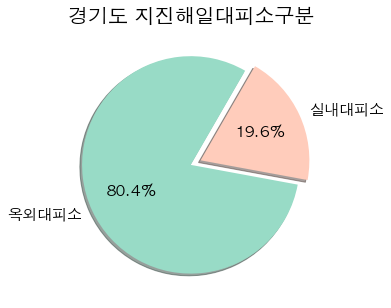

In [43]:
labels=['옥외대피소', '실내대피소']
shelter_GG['지진해일대피소유형'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%'
                    ,explode = (0,0.1) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('경기도 지진해일대피소구분', fontsize=20)
pylab.ylabel('')

## 2. 내진설계 분석
- 실내 대피소 중 내질설계가 되어있는 대피소는 얼마나 될까?


In [44]:
for_seismic = shelter_G[shelter_G['지진해일대피소유형']=='실내대피소']

# 실내 대피소만 내진설계가 가능하기 때문에 실내 대피소만 

In [45]:
seismic_design = len(for_seismic[for_seismic['내진적용여부']=='적용'])/len(for_seismic)*100
print('경인, 경기지역 내진설계 비율 =', seismic_design, '%')

경인, 경기지역 내진설계 비율 = 79.40251572327044 %


Text(0, 0.5, '')

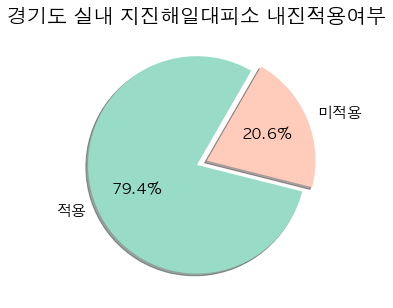

In [46]:
labels=['적용', '미적용']   #항상 파이그래프 보면서 label순서 제대로 설정했는지 확인 
for_seismic['내진적용여부'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB'] #색깔 지정 (색깔 코드 인터넷 검색)
                    ,startangle = 60                #시작 각도 설정
                    ,shadow = True                  #그림자 생성
                    ,autopct = '%1.1f%%'            # 퍼센테이지 소숫점 설정
                    ,explode = (0,0.1)              # 한 파트 톡 튀어 나오게 만들기 (꼭 파트의 수와 동일해야함 안그럼 오류 EG)4개로 구분되면 (0, 0, 0, 0.1)로 기재)
                    ,figsize=(5, 5)                 # 그래프 사이즈 설정 
                    ,fontsize = 15)                 # 글씨 크기 설정
plt.title('경기도 실내 지진해일대피소 내진적용여부', fontsize=20)   #제목명, 제목 사이즈 설정
pylab.ylabel('')    # y축 설명 없애기 

![](bk3)

### 배경지식 
- 실외대피소: 지진 또는 해일이 발생할 경우 실외대피소에서 집합 후 안내 방송에 따라 다같이 이동하기 위한 용도
- 실내대피소: 집합 또는 이재민 수용을 위한 임시주거시설로 이용

![](bk3.png)

Text(0, 0.5, '')

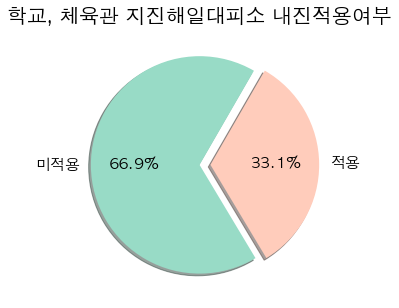

In [47]:
labels=['미적용', '적용']
shelter_G[(shelter_G['지진해일대피소유형구분']=='학교')|(['지진해일대피소유형구분']=='체육관')]['내진적용여부'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB'] #색깔 지정 (색깔 코드 인터넷 검색)
                    ,startangle = 60                #시작 각도 설정
                    ,shadow = True                  #그림자 생성
                    ,autopct = '%1.1f%%'            # 퍼센테이지 소숫점 설정
                    ,explode = (0,0.1)              # 한 파트 톡 튀어 나오게 만들기 (꼭 파트의 수와 동일해야함 안그럼 오류 EG)4개로 구분되면 (0, 0, 0, 0.1)로 기재)
                    ,figsize=(5, 5)                 # 그래프 사이즈 설정 
                    ,fontsize = 15)                 # 글씨 크기 설정
plt.title('학교, 체육관 지진해일대피소 내진적용여부', fontsize=20)   #제목명, 제목 사이즈 설정
pylab.ylabel('')    # y축 설명 없애기 

## 2. 지진해일 대피소 구분 분석
- 지진해일대피소 vs 지진대피소

In [48]:
len(shelter_G[shelter_G['지진해일대피소구분']=='지진대피소'])

3217

Text(0, 0.5, '')

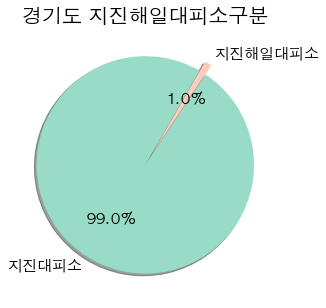

In [49]:
labels=['지진대피소', '지진해일대피소']
shelter_G['지진해일대피소구분'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%'
                    ,explode = (0,0.1) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('경기도 지진해일대피소구분', fontsize=20)
pylab.ylabel('')

## 4. 지진해일대피소유형구분 분석

In [50]:
shelter_G['지진해일대피소유형구분'].unique()

array(['공원', '운동장', '학교', '기타', '체육관', '유수지', '체육시설', '광장', '교회', '성당',
       '도서관'], dtype=object)

ValueError: 'label' must be of length 'x'

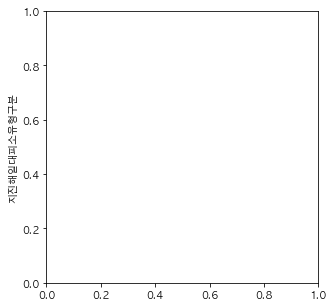

In [51]:
labels=['공원', '운동장', '학교', '기타', '체육관']
shelter_G['지진해일대피소유형구분'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6','#5BC8AC','#E6D72A','#F18D9E', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%'
                    ,explode = (0.1,0,0,0,0) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('경기도 지진해일대피소유형구분', fontsize=20)
pylab.ylabel('')

## 5. 지진해일대피소운영상태 분석

In [52]:
shelter_G['지진해일대피소운영상태'].unique()

array(['Y', 'N'], dtype=object)

Text(0, 0.5, '')

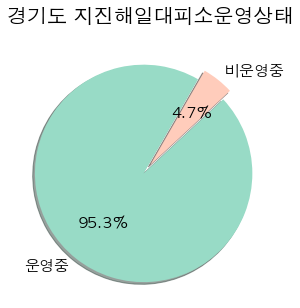

In [53]:
labels=['운영중', '비운영중']
shelter_G['지진해일대피소운영상태'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%'
                    ,explode = (0.1,0) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('경기도 지진해일대피소운영상태', fontsize=20)
pylab.ylabel('')

## 6. 지역별 대피소 수

In [54]:
shelter_G['area'].unique()

array(['서울특별시', '경기도', '인천광역시'], dtype=object)

Text(0, 0.5, '')

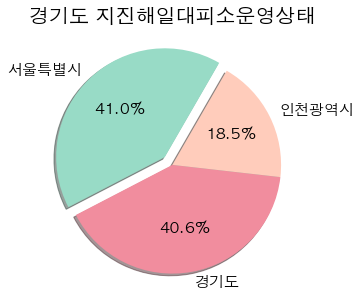

In [55]:
labels=['서울특별시', '경기도', '인천광역시']
shelter_G['area'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6','#F18D9E', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%' 
                    ,explode = (0.1,0, 0) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('경기도 지진해일대피소운영상태', fontsize=20)
pylab.ylabel('')

## 7. 지역별 대피소 지도 만들기 (HELP)
- 처음에는 전국 데이터를 한번에 찍어보려 했으나 데이터가 너무 많아 지도가 뜨지 않음 
- 8도로 나누어 시도 -> 서울, 인천, 경기 3곳 모두 데이터 양이 많아 지도 안뜸 


## 서울 지도

In [119]:
shelter_seoul = shelter_G[shelter_G['area']=='서울특별시']
# map = folium.Map(location=[35.9078, 127.7669], zoom_start = 6, tiles ='Mapbox bright')
# fg = folium.FeatureGroup(name = '서울지진해일대피소')
# for lat, lon, name in zip(shelter_seoul['위도'], shelter_seoul['경도'], shelter_seoul['지진해일대피소명']):
#     fg.add_child(folium.Marker(location=[lat, lon], popup=(folium.Popup(name)), icon=folium.Icon(icon = 'cloud', color= 'blue', icon_color = 'white')))
# map.add_child(fg)
# map.save(outfile='서울.html')

## 인천광역시 지도

In [120]:
shelter_incheon = shelter_G[shelter_G['area']=='인천광역시']
# map = folium.Map(location=[35.9078, 127.7669], zoom_start = 6, tiles ='Mapbox bright')
# fg = folium.FeatureGroup(name = '인천지진해일대피소')
# for lat, lon, name in zip(shelter_incheon['위도'], shelter_incheon['경도'], shelter_incheon['지진해일대피소명']):
#     fg.add_child(folium.Marker(location=[lat, lon], popup=(folium.Popup(name)), icon=folium.Icon(icon = 'cloud', color= 'blue', icon_color = 'white')))
# map.add_child(fg) 
# map.save(outfile='인천.html')

## 경기도 지도

In [121]:
shelter_ggi = shelter_G[shelter_G['area']=='경기도']
# map = folium.Map(location=[35.9078, 127.7669], zoom_start = 6, tiles ='Mapbox bright')
# fg = folium.FeatureGroup(name = '경기지진해일대피소')
# for lat, lon, name in zip(shelter_ggi['위도'], shelter_ggi['경도'], shelter_ggi['지진해일대피소명']):
#     fg.add_child(folium.Marker(location=[lat, lon], popup=(folium.Popup(name)), icon=folium.Icon(icon = 'cloud', color= 'blue', icon_color = 'white')))
# map.add_child(fg) 
# map.save(outfile='경기.html')

## 8. 지역별 인구수 대비 최대수용가능 인원수 비교

- 서울, 인천: 구 단위
- 경기도: 시 단위 
- (인구 통계가 위와 같은 단위로 분리되어있기 때문)

### 과정
1. KOSIS에서 서울, 인천, 경기도 인구 통계 불러옴 

2. 서울특별시, 인천광역시, 경기도 행 제거 (각 구 또는 시 인구 수의 합)

3. 서울 중구, 인천 중구 합쳐지는 문제 발생 
    - 인구 통계 테이블을 각 지역별로 분리하여 따로 저장 
    - 구 또는 시 이름 앞 '서울특별시', '인천광역시', '경기도' 붙여줌 
    - 다시 하나의 테이블로 합침

4. 인구 통계 테이블의 지역명과 대피소 테이블의 '제공기관명'과 분류가 동일해 '제공기관명'을 기준으로 LEFT JOIN 
    - 인구 통계 테이블에는 있지만 대피소 테이블에는 없는 지역 (=대피소 데이터가 없는 지역) 찾음 
    - 공공데이터 포털에 데이터 요청 
    - 국민재난안전포털에서 데이터 긁어옴

5. 제공기관명(지역명)으로 groupby한 후, 최대수용인원수를 sum 해서 지역별 최대수용인원수 컬럼 생성 

6. '지역 인구수 - 지역 최대수용인원수'를 'diff'컬럼에 저장 

7. diff가 마이너스면 '불충분', 플러스면 '충분'으로 지정


### 데이터 없는 지역 
- 서울특별시 용산구 
- 서울특별시 성동구
- 서울특별시 동대문구
- 서울특별시 성북구
- 서울특별시 도봉구
- 서울특별시 마포구
- 서울특별시 구로구
- 서울특별시 강동구
- 경기도 용인시
- 경기도 안양시
- 경기도 연천군

In [59]:
ppl = pd.read_csv('population.csv', encoding = "CP949")

# http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3

In [60]:
ppl.head()

,행정구역(시군구)별,2019. 09
0,행정구역(시군구)별,총인구수 (명)
1,서울특별시,9740398
2,종로구,151767
3,중구,126409
4,용산구,228830


In [61]:
len(ppl)

87

In [62]:
ppl[(ppl['행정구역(시군구)별']=='행정구역(시군구)별')|(ppl['행정구역(시군구)별']=='서울특별시')|(ppl['행정구역(시군구)별']=='인천광역시')|(ppl['행정구역(시군구)별']=='경기도')]

,행정구역(시군구)별,2019. 09
0,행정구역(시군구)별,총인구수 (명)
1,서울특별시,9740398
27,인천광역시,2956804
38,경기도,13207219


In [63]:
ppl = ppl.drop([ppl.index[0], ppl.index[1], ppl.index[27], ppl.index[38]])

In [64]:
ppl

,행정구역(시군구)별,2019. 09
2,종로구,151767
3,중구,126409
4,용산구,228830
5,성동구,303158
6,광진구,352692
7,동대문구,346551
8,중랑구,398812
9,성북구,441590
10,강북구,314090
11,도봉구,335280


In [65]:
# 분석 쉽도로 컬럼명 변경 
ppl = ppl.rename(columns={'행정구역(시군구)별': 'sigungu', '2019. 09': 'nop'}) #nop: number of people

In [66]:
#.iloc으로 [25번째 열까지, 모든 컬럼] 잘라내서 '서울' 테이블로 지정 
서울 = ppl.iloc[:25, :].copy()

In [67]:
# 서울 구 이름 앞에 서울특별시 붙여넣기
서울['sigungu'] = '서울특별시' + ' ' + 서울.sigungu.str[0:] #future warning 무시 -> 해결방법을 찾아야하지만....ㅎ 

In [68]:
서울

,sigungu,nop
2,서울특별시 종로구,151767
3,서울특별시 중구,126409
4,서울특별시 용산구,228830
5,서울특별시 성동구,303158
6,서울특별시 광진구,352692
7,서울특별시 동대문구,346551
8,서울특별시 중랑구,398812
9,서울특별시 성북구,441590
10,서울특별시 강북구,314090
11,서울특별시 도봉구,335280


In [69]:
인천 = ppl.iloc[25:35, :]

In [70]:
인천['sigungu'] = '인천광역시' + ' ' + 인천.sigungu.str[0:]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
인천

,sigungu,nop
28,인천광역시 중구,132052
29,인천광역시 동구,64718
30,인천광역시 미추홀구,410998
31,인천광역시 연수구,362254
32,인천광역시 남동구,533560
33,인천광역시 부평구,514856
34,인천광역시 계양구,305394
35,인천광역시 서구,543108
36,인천광역시 강화군,69138
37,인천광역시 옹진군,20726


In [72]:
경기도 = ppl.iloc[35:, :]   #.drop(ppl.index[35:42]).drop(ppl.index[43:45]).drop(ppl.index[49:54]).drop(ppl.index[62:65])

In [73]:
경기도['sigungu'] = '경기도' + ' ' + 경기도.sigungu.str[0:]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
경기도

,sigungu,nop
39,경기도 수원시,1196074
40,경기도 장안구,279819
41,경기도 권선구,372825
42,경기도 팔달구,177063
43,경기도 영통구,366367
44,경기도 성남시,944741
45,경기도 수정구,234570
46,경기도 중원구,221234
47,경기도 분당구,488937
48,경기도 의정부시,451846


In [75]:
# 수원 = ppl.iloc[35:39, :]
# 수원['sigungu'] = '경기도' + ' ' + '수원시'+' ' + 수원.sigungu.str[0:]

In [76]:
# 성남 = ppl.iloc[39:42, :]
# 성남['sigungu'] = '경기도' + ' ' + '성남시'+' ' + 성남.sigungu.str[0:]

In [77]:
# 안양 = ppl.iloc[43:45, :]
# 안양['sigungu'] = '경기도' + ' ' + '안양시'+' ' + 안양.sigungu.str[0:]

In [78]:
# 안산 = ppl.iloc[49:51, :]
# 안산['sigungu'] = '경기도' + ' ' + '안산시'+' ' + 안산.sigungu.str[0:]

In [79]:
# 고양 = ppl.iloc[51:54, :]
# 고양['sigungu'] = '경기도' + ' ' + '고양시'+' ' + 고양.sigungu.str[0:]

In [80]:
# 용인 = ppl.iloc[62:65, :]
# 용인['sigungu'] = '경기도' + ' ' + '용인시'+' ' + 용인.sigungu.str[0:]

In [81]:
ppl_final = pd.concat([서울, 인천, 경기도], ignore_index=True)

In [82]:
len(ppl_final)

83

In [83]:
# 제공기관명이 시이름 + 구이름 으로 되어 있어서 이 컬럼을 기준으로 join 할 예정
shelter_G.제공기관명.unique()

array(['서울특별시 종로구', '경기도 시흥시', '인천광역시 동구', '서울특별시 중랑구', '인천광역시 계양구',
       '서울특별시 동작구', '경기도 양평군', '경기도 김포시', '경기도 오산시', '경기도 의정부시',
       '인천광역시 부평구', '서울특별시 영등포구', '인천광역시 옹진군', '경기도 양주시', '경기도 구리시',
       '경기도 과천시', '서울특별시 송파구', '서울특별시 강서구', '서울특별시 은평구', '경기도 의왕시',
       '인천광역시 중구', '서울특별시 관악구', '경기도 동두천시', '서울특별시 중구', '인천광역시 서구',
       '경기도 가평군', '경기도 포천시', '서울특별시 금천구', '경기도 남양주시', '경기도 고양시',
       '서울특별시 광진구', '서울특별시 서대문구', '경기도 화성시', '서울특별시 서초구', '경기도 군포시',
       '경기도 성남시', '경기도 부천시', '인천광역시 연수구', '경기도 여주시', '서울특별시 노원구',
       '경기도 안성시', '경기도 파주시', '경기도 안산시', '경기도 이천시', '서울특별시 강남구', '경기도 평택시',
       '서울특별시 양천구', '경기도 수원시', '경기도 광주시', '경기도 하남시', '인천광역시 남동구',
       '인천광역시 미추홀구', '경기도 광명시'], dtype=object)

In [84]:
# 인구테이블과 join하기 위해 필요한 두개 컬럼만 shelter_ppl이라는 테이블로 저장
shelter_ppl = shelter_G[['최대수용인원수', '제공기관명']]

In [85]:
# 제공기관명으로 groupby해서 그 지역 내 모든 대피소 최대수용인원수 더하기
shelter_capacity_temp= pd.DataFrame(shelter_ppl.groupby('제공기관명')['최대수용인원수'].sum())

In [86]:
shelter_capacity_temp

,최대수용인원수
제공기관명,
경기도 가평군,24315.0
경기도 고양시,125398.0
경기도 과천시,86889.0
경기도 광명시,744810.0
경기도 광주시,232907.0
경기도 구리시,4533.0
경기도 군포시,192551.0
경기도 김포시,555246.0
경기도 남양주시,20926.0


In [87]:
find_missing_area = ppl_final.merge(shelter_capacity_temp, how='left', left_on=['sigungu'], right_on=['제공기관명'])

In [88]:
find_missing_area[find_missing_area['최대수용인원수'].isnull()] #뭐죠? 왜죠? 왜 없죠?

,sigungu,nop,최대수용인원수
2,서울특별시 용산구,228830,NaN
3,서울특별시 성동구,303158,NaN
5,서울특별시 동대문구,346551,NaN
7,서울특별시 성북구,441590,NaN
8,서울특별시 강북구,314090,NaN
9,서울특별시 도봉구,335280,NaN
13,서울특별시 마포구,373629,NaN
16,서울특별시 구로구,406748,NaN
24,서울특별시 강동구,426219,NaN
33,인천광역시 강화군,69138,NaN


In [89]:
shelter_G[shelter_G['제공기관명'] == '인천광역시 남동구']

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29,area,위,경
3043,구월초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 인주대로721번길 49(구월동),NaN,37.451896,126.716762,2422.0,2935.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3044,만월초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 선수촌로 28(구월동),NaN,37.441988,126.715346,3544.0,4295.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3045,성리초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 성리로 32-2 (구월동),NaN,37.445641,126.710021,6540.0,7927.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3046,구월근린공원,지진대피소,옥외대피소,공원,인천광역시 남동구 구월로 251(구월동),NaN,37.458350,126.718961,17000.0,20606.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3047,간석초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 석산로208번길 37(구월동),NaN,37.458885,126.716077,6500.0,7878.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3048,석천초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 남동대로 828(구월동),NaN,37.456273,126.709469,6149.0,7453.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3049,정각초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 구월로 228(구월동),NaN,37.455651,126.715668,3884.0,4707.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3050,인천시청 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 정각로 29(구월동),NaN,37.455765,126.706188,4050.0,4909.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3051,구월서초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 문화서로77번길 14(구월동),NaN,37.452792,126.695765,6604.0,8004.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3052,구월여자중학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 성말로13번길 78(구월동),NaN,37.448672,126.703215,6331.0,7673.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN


In [90]:
shelter_G[shelter_G['소재지도로명주소'].str[0:9]=='인천광역시 남동구']

,지진해일대피소명,지진해일대피소구분,지진해일대피소유형,지진해일대피소유형구분,소재지도로명주소,소재지지번주소,위도,경도,수용가능면적,최대수용인원수,...,지진대피로안내표지판수,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 29,area,위,경
3043,구월초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 인주대로721번길 49(구월동),NaN,37.451896,126.716762,2422.0,2935.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3044,만월초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 선수촌로 28(구월동),NaN,37.441988,126.715346,3544.0,4295.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3045,성리초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 성리로 32-2 (구월동),NaN,37.445641,126.710021,6540.0,7927.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3046,구월근린공원,지진대피소,옥외대피소,공원,인천광역시 남동구 구월로 251(구월동),NaN,37.458350,126.718961,17000.0,20606.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3047,간석초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 석산로208번길 37(구월동),NaN,37.458885,126.716077,6500.0,7878.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3048,석천초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 남동대로 828(구월동),NaN,37.456273,126.709469,6149.0,7453.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3049,정각초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 구월로 228(구월동),NaN,37.455651,126.715668,3884.0,4707.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3050,인천시청 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 정각로 29(구월동),NaN,37.455765,126.706188,4050.0,4909.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3051,구월서초등학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 문화서로77번길 14(구월동),NaN,37.452792,126.695765,6604.0,8004.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN
3052,구월여자중학교 운동장,지진대피소,옥외대피소,운동장,인천광역시 남동구 성말로13번길 78(구월동),NaN,37.448672,126.703215,6331.0,7673.0,...,NaN,인천광역시 남동구청,032-453-2330,2018-12-04,3530000.0,인천광역시 남동구,NaN,인천광역시,NaN,NaN


In [91]:
# join 하기
shelter_capacity = shelter_capacity_temp.merge(ppl_final, how='left', left_on=['제공기관명'], right_on=['sigungu'])

In [92]:
shelter_capacity

,최대수용인원수,sigungu,nop
0,24315.0,경기도 가평군,62743
1,125398.0,경기도 고양시,1059340
2,86889.0,경기도 과천시,58043
3,744810.0,경기도 광명시,319205
4,232907.0,경기도 광주시,370411
5,4533.0,경기도 구리시,199595
6,192551.0,경기도 군포시,274667
7,555246.0,경기도 김포시,434344
8,20926.0,경기도 남양주시,699326
9,29709.0,경기도 동두천시,94912


In [93]:
shelter_capacity.columns

Index(['최대수용인원수', 'sigungu', 'nop'], dtype='object')

In [94]:
shelter_capacity.sample(10)

,최대수용인원수,sigungu,nop
9,29709.0,경기도 동두천시,94912
50,847760.0,인천광역시 연수구,362254
26,2540.0,경기도 하남시,269539
46,32783.0,인천광역시 동구,64718
44,425611.0,인천광역시 계양구,305394
11,12241.0,경기도 성남시,944741
43,40856.0,서울특별시 중랑구,398812
49,60162.0,인천광역시 서구,543108
40,138487.0,서울특별시 은평구,481663
52,1307513.0,인천광역시 중구,132052


In [95]:
# 분석 용이하게 하기 위해 컬럼명 변경 
shelter_capacity.rename(columns={'최대수용인원수':'max'}, inplace=True)

In [96]:
len(shelter_capacity)

53

In [97]:
# max 컬럼이 float64이기때문에 정확한 비교를 위해 타입 변경
shelter_capacity['nop'] = shelter_capacity['nop'].astype('float64')

In [98]:
shelter_capacity[shelter_capacity['nop']>shelter_capacity['max']]

,max,sigungu,nop
0,24315.0,경기도 가평군,62743.0
1,125398.0,경기도 고양시,1059340.0
4,232907.0,경기도 광주시,370411.0
5,4533.0,경기도 구리시,199595.0
6,192551.0,경기도 군포시,274667.0
8,20926.0,경기도 남양주시,699326.0
9,29709.0,경기도 동두천시,94912.0
10,25845.0,경기도 부천시,833218.0
11,12241.0,경기도 성남시,944741.0
12,475265.0,경기도 수원시,1196074.0


In [99]:
# 두 컬럼의 차를 diff 컬럼에 저장
shelter_capacity['diff'] = shelter_capacity['max']-shelter_capacity['nop']

In [100]:
shelter_capacity['diff'].max()

1175461.0

In [101]:
shelter_capacity['diff'].min()

-933942.0

In [102]:
shelter_capacity[shelter_capacity['diff']==shelter_capacity['diff'].max()]

,max,sigungu,nop,diff
52,1307513.0,인천광역시 중구,132052.0,1175461.0


In [103]:
shelter_capacity[shelter_capacity['sigungu'] =='인천광역시 중구']

,max,sigungu,nop,diff
52,1307513.0,인천광역시 중구,132052.0,1175461.0


In [104]:
# 값이 마이너스면 불충분, 플러스면 충분으로 지정
shelter_capacity['capacity'] = shelter_capacity['diff'].apply(lambda x: '불충분' if x<0 else '충분' )

In [105]:
len(shelter_capacity[shelter_capacity['nop']>shelter_capacity['max']])

38

In [106]:
shelter_capacity[shelter_capacity['nop']==shelter_capacity['nop'].max()]

,max,sigungu,nop,diff,capacity
12,475265.0,경기도 수원시,1196074.0,-720809.0,불충분


In [107]:
shelter_capacity.sort_values('nop', ascending = False).head(5)

,max,sigungu,nop,diff,capacity
12,475265.0,경기도 수원시,1196074.0,-720809.0,불충분
1,125398.0,경기도 고양시,1059340.0,-933942.0,불충분
11,12241.0,경기도 성남시,944741.0,-932500.0,불충분
10,25845.0,경기도 부천시,833218.0,-807373.0,불충분
27,96832.0,경기도 화성시,803252.0,-706420.0,불충분


In [108]:
shelter_capacity.sort_values('max', ascending = False).head(5)

,max,sigungu,nop,diff,capacity
52,1307513.0,인천광역시 중구,132052.0,1175461.0,충분
50,847760.0,인천광역시 연수구,362254.0,485506.0,충분
3,744810.0,경기도 광명시,319205.0,425605.0,충분
14,738798.0,경기도 안산시,654668.0,84130.0,충분
48,713997.0,인천광역시 부평구,514856.0,199141.0,충분


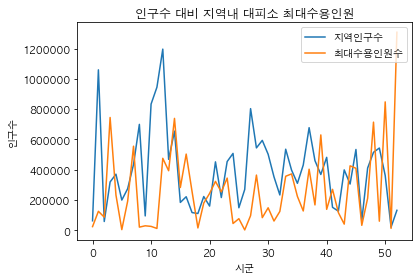

In [109]:
line_chart1 = plt.plot(shelter_capacity['nop'])
line_chart2 = plt.plot(shelter_capacity['max'])
plt.title('인구수 대비 지역내 대피소 최대수용인원')
plt.xlabel('시군')
plt.ylabel('인구수')
plt.legend(['지역인구수', '최대수용인원수'], loc = 1)
plt.show()

Text(0, 0.5, '')

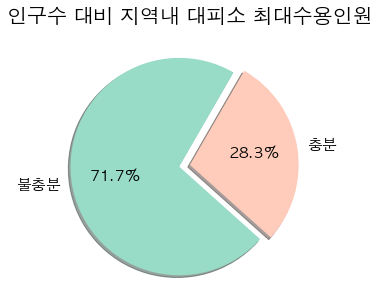

In [110]:
labels=['불충분', '충분']
shelter_capacity['capacity'].value_counts().plot.pie(labels = labels
                    ,colors= ['#98DBC6', '#FFCCBB']
                    ,startangle = 60
                    ,shadow = True
                    ,autopct = '%1.1f%%'
                    ,explode = (0.1,0) 
                    ,figsize=(5, 5)
                    ,fontsize = 15)
plt.title('인구수 대비 지역내 대피소 최대수용인원', fontsize=20)
pylab.ylabel('')

## 트러블 슈팅 
- 지진해일대피소 데이터가 없는 시, 구가 있다 	
    - 공공데이터 포털에 요청 
    - 국민재난안전포탈에서 끌어옴 
- 인천 중구, 서울 중구, 경기도 광주, 광주광역시와 같이 지역명 혼동 
    - 구 이름 앞에 시 이름을 붙여 구분 후 분석
- API로 위도 경도 결측치 채우기 
    - KAKAO, LacationIQ 둘다 해도 안나오는 데이터 있음 	
        - 노가다로 채움 
- 서울, 인천, 경기 각 지역 대피소 수가 많아서 지도가 안돌아감
    - 방법이 필요
- 세종시 데이터에는 중복 데이터가 있음
    - 중복 데이터 확인 후 제거 
    - 중복 이유 문의 예정 
    

### 역할분배
- 지역별로 나누어 분석중 


### 앞으로 더 해볼 것 (hopes & dreams)
- 대피소에서 더 나아가 '행정안전부_이재민임시주거시설정보'데이터를 분석하여 실내대피소와 임시주거시설 비교
- 인구수 대비 최대수용인원 부족하면 색깔이 진하게 히트맵으로 시각화하여 문제가 심각한 지역 찾기
- 지진 데이터를 보며 지진이 자주 일어나는 지역을 찾아보고 집중 분석 
- 지진대피소와 지진해일대피소의 구분 등 더 많은 배경지식 조사
- 구 또는 시 단위가 아닌 동 단위로 인구 수 대비 최대수용가능 인원수 분석 
- 개선 방안 모색 
     - 대피소 불충분 지역에 대피소를 증축한다면 위치 최적화 (입지 분석)
     - 현재 위치 기반 최단거리 대피소 추천 
     - 재난 위치에 따른 대피소 추천 
- 8월 18일 마감인 '서울특별시 빅데이터 캠퍼스 공모전' 준비 

### 동기 & 선미님께 받고 싶은 도움 
- 데이터가 많아서 지도가 안돌아가는데 어떡하나요? 
- 최적 위치 선정을 하고 싶은데 도움이 될만한 강의 또는 글이 있을까요?
- 데이터가 없는 지역 데이터 요청했는데 이유도 안말해주고 거절당했어요....안전처에서 재난소 위치는 가져올수 있지만 데이터가 많이 부족한데 이거 어떻게 하면 좋을까요?
- 피드백 주세요~~

# 수민_지도수정

### 서울

In [122]:
shelter_seoul.shape

(1319, 33)

In [123]:
shelter_seoul['위도'] = shelter_seoul['위도'].replace(np.nan, 0, regex = True)
shelter_seoul['경도'] = shelter_seoul['경도'].replace(np.nan, 0, regex = True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [124]:
coordinates_seoul = shelter_seoul[['위도', '경도']]
coordinates_seoul.head()

,위도,경도
0,37.572387,126.971583
1,37.581920,126.987930
2,37.572915,126.961601
3,37.577918,126.982867
4,37.577945,126.981778


In [125]:
coordinates_seoul.isnull().sum()

위도    0
경도    0
dtype: int64

## 30분 이내 도착 수용가능 범위

In [160]:
# 지도 준비

map = Map(location=[37.55, 127], zoom_start=11)

# 지도에 위치 표시

for lat, lng in coordinates_seoul.values:
    marker = folium.Circle(
        location=[lat, lng],
        radius=2_250,
        weight=1,
        color = 'rgb(0, 255, 0)',
#         opacity=0.05,
        fill_color='rgb(0, 255, 0)',
        fill_opacity=0.05,
    )
    marker.add_to(map)
map.save(outfile='서울_30분.html')

map

## 10분 이내 도착 수용가능범위

In [161]:
# 지도 준비

map = Map(location=[37.55, 127], zoom_start=11)

# 지도에 위치 표시

for lat, lng in coordinates_seoul.values:
    marker = folium.Circle(
        location=[lat, lng],
        radius=750,
        weight=1,
        color = 'rgb(0, 255, 0)',
#         opacity=0.2,
        fill_color='rgb(0, 255, 0)',
        fill_opacity=0.2,
    )
    marker.add_to(map)
map.save(outfile='서울_10분.html')

map

### 경기

In [134]:
shelter_ggi.shape

(1331, 33)

In [135]:
coordinates_ggi = shelter_ggi[['위도', '경도']]

In [136]:
# 지도 준비

map = Map(location=[37.5, 126.9], zoom_start=9)

# 지도에 위치 표시

for lat, lng in coordinates_ggi.values:
    marker = folium.Circle(
        location=[lat, lng],
        radius=2_250,
        weight=1,
        fill_color='#F00',
        fill_opacity=0.3,
    )
    marker.add_to(map)

map

### 인천

In [137]:
shelter_incheon.shape

(600, 33)

In [138]:
coordinates_incheon = shelter_incheon[['위도', '경도']]

In [139]:
# 지도 준비

map = Map(location=[37.4, 126.4], zoom_start=10)

# 지도에 위치 표시

for lat, lng in coordinates_incheon.values:
    marker = folium.Circle(
        location=[lat, lng],
        radius=1_000,
        weight=1,
        fill_color='#F00',
        fill_opacity=0.3,
    )
    marker.add_to(map)

map